<a href="https://colab.research.google.com/github/giordamaug/BIOMAT2022/blob/main/notebooks/BIOMAT2022_workbench_allproblems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Cloning BIOMAT2022 repository

In [1]:
!git clone http://github.com/giordamaug/BIOMAT2022
!pip install -q lightgbm
!pip install -q tabulate
%cd /content/BIOMAT2022

Cloning into 'BIOMAT2022'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 693 (delta 374), reused 683 (delta 364), pack-reused 0
Receiving objects: 100% (693/693), 580.44 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (374/374), done.
Checking out files: 100% (112/112), done.
/content/BIOMAT2022


# Import required packages

In [2]:
import pandas as pd
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
	import tqdm.notebook as tq
else:
	import tqdm as tq
import pandas as pd


## Inititialization of some parameters

In [3]:
#@title  { form-width: "10%" }
seed = 0 #@param {type:"integer"}
class bcolors:
    HEADER = '\033[95m\033[1m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

classifier_map = {'RF' : 'RandomForestClassifier', 
                  'MLP': 'MLPClassifier', 
                  'SVM' : 'SVC', 
                  'RUS':  'RUSBoostClassifier',
                  'XGB': 'XGBClassifier',
                  'LGBM': 'LGBMClassifier'}

classifiers_args = {
  'RF' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'MLP': {'random_state' : seed}, 
  'SVM' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'RUS': {'random_state' : seed},
  'XGB': {'random_state' : seed, 'eval_metric' : 'logloss', 'scale_pos_weight' : 0.2},
  'LGBM': {'random_state' : seed, 'class_weight': 'balanced'}
}

# Load labels
Gene labels are loaded before gene attributes loading. 
The final list of genes `selectedgenes` is the intersection of the subset of genes with attributes and the subset of labelled genes.

In [4]:
#@title  { form-width: "30%" }
data_dir = "KIDNEY" #@param {type:"string"}
label_filename = "node_labels.csv" #@param {type:"string"}
labelname = "most_freq" #@param {type:"string"}
problem = "E vs NE" #@param ["E vs NE", "E vs aE vs aNE vs NE", "(E + aE) vs (aNE + NE)", "(E) vs (aNE + NE)", "E vs aNE vs NE"]
if problem == "E vs NE":
  label_aliases = {}
  exclude_labels = ['aE', 'aNE']
elif problem == "E vs aE vs aNE vs NE":
  label_aliases = {}
  exclude_labels = []
elif problem == "(E + aE) vs (aNE + NE)":
  label_aliases = {'aE' : 'E + aE', 'E' : 'E + aE', 'aNE' : 'aNE + NE', 'NE' : 'aNE + NE'}
  exclude_labels = []
elif problem == "(E) vs (aNE + NE)":
  label_aliases = {'aNE' : 'aNE + NE', 'NE' : 'aNE + NE'}
  exclude_labels = ['aE']
elif problem == "E vs aNE vs NE":
  label_aliases = {}
  exclude_labels = ['aE']
else:
  print(bcolors.FAIL + f'\tWrong problem {problem}!' + bcolors.ENDC)
label_file = os.path.join(data_dir, "node_labels.csv")
df_label = pd.read_csv(label_file, sep=',', index_col=0)
dup = df_label.index.duplicated().sum()     # remove duplicated genes
if dup > 0:
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    df_label = df_label[~df_label.index.duplicated(keep='first')]
if labelname in df_label.columns:
    print(bcolors.HEADER + f'Loading label {labelname} from file "{label_file}"...' + bcolors.ENDC)
else:
    print(bcolors.FAIL + f'FAIL: Label name {labelname} is not in the label file {label_filename}!' + bcolors.ENDC)
genes = df_label.index.values                                            # get genes with defined labels
df_label = df_label[df_label[labelname].isin([np.nan] + exclude_labels) == False]                      # drop any row contaning NaN or SC1-SC5 as value
labels = np.unique(df_label[labelname].values)  
print(bcolors.OKGREEN + f'\tOriginal label values in {labels}' + bcolors.ENDC)
for key,newkey in label_aliases.items():
    if key in labels:
        print(bcolors.OKGREEN + f'\treplacing label {key} with {newkey}' + bcolors.ENDC)
        df_label = df_label.replace(key, newkey)

print(bcolors.OKGREEN + f'\tFinal label values in {labels}' + bcolors.ENDC)
selectedgenes = df_label.index.values
print(bcolors.OKGREEN + f'\t{len(selectedgenes)} labeled genes over a total of {len(genes)}' + bcolors.ENDC)
df_label

Loading label most_freq from file "KIDNEY/node_labels.csv"...
	Original label values in ['E' 'NE']
	Final label values in ['E' 'NE']
	6014 labeled genes over a total of 17386


,ACH-000159,ACH-000189,ACH-000234,ACH-000246,ACH-000250,ACH-000262,ACH-000272,ACH-000313,ACH-000317,ACH-000375,...,ACH-001163,ACH-001194,ACH-001310,ACH-001398,ACH-001532,ACH-001687,ACH-001688,ACH-002150,ACH-002189,most_freq
name,,,,,,,,,,,,,,,,,,,,,
A2ML1,aNE,NE,NE,aNE,NE,NE,NE,NE,aNE,aNE,...,NE,NE,aNE,NE,NE,NE,NE,NE,NE,NE
AADAC,NE,NE,aNE,NE,NE,aNE,NE,aNE,aNE,NE,...,NE,aNE,aNE,NE,aNE,NE,NE,NE,NE,NE
AADACL3,NE,NE,NE,NE,NE,NE,aNE,aNE,NE,aNE,...,aNE,aNE,aNE,NE,NE,NE,NE,NE,aNE,NE
AADACL4,NE,aNE,aNE,NE,NE,aNE,NE,aNE,NE,NE,...,NE,NE,NE,aNE,NE,NE,aNE,NE,NE,NE
AAGAB,NE,NE,aNE,NE,NE,NE,NE,NE,NE,aNE,...,aNE,NE,NE,NE,aNE,aNE,NE,NE,NE,NE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,NE,NE,aNE,NE,NE,aNE,NE,aNE,NE,NE,...,NE,NE,aNE,NE,NE,NE,NE,NE,aNE,NE
ZSWIM3,NE,aNE,NE,NE,NE,NE,aNE,NE,NE,aNE,...,NE,NE,NE,aNE,NE,NE,NE,NE,aNE,NE
ZSWIM6,aNE,aNE,aNE,aNE,NE,aNE,NE,NE,aNE,aNE,...,NE,NE,NE,aNE,NE,NE,aNE,NE,aNE,NE


 # Load gene attributes

Fixing NaN and infinity values

In [5]:

attr_filename = "node_attributes.csv" #@param {type:"string"}
x = pd.read_csv(os.path.join(data_dir, attr_filename), index_col=0)
x = x.select_dtypes(include=np.number)     # drop non numeric attributes
dup = x.index.duplicated().sum()
if dup > 0:                         # removing duplicated genes
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    x = x[~x.index.duplicated(keep='first')]
droppedcol = 0
nancount = x.isnull().sum().sum()
for col in x.columns[x.isna().any()].tolist():
    mean_value=x[col].mean()          # Replace NaNs in column with the mean of values in the same column
    if mean_value is not np.nan:
        x[col].fillna(value=mean_value, inplace=True)
    else:                             # otherwise, if the mean is NaN, remove the column
        x = x.drop(col, 1)
print(bcolors.HEADER + f'Fix: {nancount} NaN values - {np.isinf(x).values.sum()} Infinite value - {droppedcol} dropped null columns' + bcolors.ENDC)


	Removing 18 duplicated genes...
Fix: 77207 NaN values - 0 Infinite value - 0 dropped null columns


data normalization

In [6]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

normalize_node = "zscore" #@param ["minmax", "zscore", ""]
if normalize_node == 'minmax':
    print(bcolors.OKGREEN + "\tgene attributes normalization (minmax)..." + bcolors.ENDC)
    x = (x-x.min())/(x.max()-x.min())
elif normalize_node == 'zscore':
    print(bcolors.OKGREEN + "\tgene attributes normalization (zscore)..." + bcolors.ENDC)
    x = (x-x.mean())/x.std()
selectedgenes = intersection(x.index.to_list(), selectedgenes)
print(bcolors.OKGREEN + f'\tgenes with attributes are {len(selectedgenes)}' + bcolors.ENDC)
x = x.loc[selectedgenes]
x = x[~x.index.duplicated(keep='first')]   # remove eventually duplicated index
print(bcolors.OKGREEN + f'\tNew attribute matrix x{x.shape}' + bcolors.ENDC)
x

	gene attributes normalization (zscore)...
	genes with attributes are 5661
	New attribute matrix x(5661, 28)


,gene_length,transcript_count,gc_content,Gtex_kidney,gene_disease_ass_count,oncodb_expression,HPA_kidney_match_symbol,mf,bp,cc,...,Endosome,Golgi apparatus,Cytosol,Plasma membrane,Endoplasmic reticulum,Cytoskeleton,Peroxisome,Lysosome,Extracellular space,Vacuole
name,,,,,,,,,,,,,,,,,,,,,
A2ML1,-0.043297,0.014380,-0.313841,-4.160265e-02,-1.689862e-01,2.917271e-17,-0.057968,-0.158574,-0.632539,-0.538078,...,-1.079567e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,-1.007248e+00,8.695179e-01,0.747457,0.775120
AADAC,-0.424081,-0.740323,-1.466631,-4.161297e-02,-7.095427e-01,2.917271e-17,-0.057722,0.705766,-0.541261,-0.795246,...,-1.079567e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,1.109923e+00,8.695179e-01,0.747457,0.775120
AAGAB,-0.118380,-0.201249,-0.928318,-2.530817e-02,-4.392645e-01,-1.629153e-01,-0.023876,-1.022914,-0.723817,-0.538078,...,1.035570e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,-2.520897e+00,-1.007248e+00,8.695179e-01,-1.495694,0.775120
AARS1,-0.246443,3.572267,0.376801,5.924644e-18,-6.194500e-01,2.917271e-17,-0.003815,1.281993,-0.084872,-0.023742,...,2.348274e-16,0.000000,-4.354059e-16,3.518540e-16,0.000000,3.291120e-16,1.175266e-16,2.392809e-16,0.000000,0.000000
AASS,0.073647,1.955046,-1.307848,-3.586163e-02,4.616631e-01,-9.553400e-01,-0.040738,1.281993,-0.358705,0.233426,...,-1.079567e+00,-1.259487,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,1.109923e+00,-1.285733e+00,-1.495694,-1.442316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,-0.368311,-0.740323,-1.807433,-4.162428e-02,-1.600369e-16,2.917271e-17,-0.057968,-0.446688,-0.541261,0.000000,...,-1.079567e+00,-1.259487,3.094892e-01,4.043468e-01,-1.720596,4.434800e-01,-1.007248e+00,-1.285733e+00,-1.495694,-1.442316
ZSWIM3,-0.370026,-0.848138,-0.014347,-4.010198e-02,-1.600369e-16,1.030276e+00,-0.055753,-0.734801,0.000000,0.000000,...,-1.079567e+00,-1.259487,3.094892e-01,-2.764873e+00,-1.720596,-2.520897e+00,-1.007248e+00,-1.285733e+00,-1.495694,-1.442316
ZSWIM6,1.096304,-0.848138,-1.094846,-3.661269e-02,-4.392645e-01,9.255708e-01,-0.052676,-1.022914,-0.632539,-1.052414,...,-1.079567e+00,-1.259487,3.094892e-01,-2.764873e+00,0.649756,-2.520897e+00,1.109923e+00,-1.285733e+00,-1.495694,-1.442316


# Load gene embedding

In [7]:
embed_dir = os.path.join(data_dir, "embeddings")
embedder = "Node2Vec" #@param ["Node2Vec", "GLEE", "DeepWalk"]
embedsize = 64 #@param {type:"slider", min:32, max:128, step:32}
print(bcolors.HEADER + f'Embedding with method "{embedder}" and size {embedsize}...' + bcolors.ENDC)
embedfilename = os.path.join(embed_dir,f'PPI_{embedder}_{embedsize}.csv')
embedding_df = pd.read_csv(embedfilename, index_col=0)
dup = embedding_df.index.duplicated().sum()
if dup > 0:
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    embedding_df = embedding_df[~embedding_df.index.duplicated(keep='first')]
embedding_df = embedding_df.loc[selectedgenes]
#print(embedding_df)                                     # keep only embeddings of selected genes (those with labels)
x = pd.concat([embedding_df, x], axis=1)
print(bcolors.OKGREEN + f'\tNew attribute matrix x{x.shape}' + bcolors.ENDC)
x

Embedding with method "Node2Vec" and size 64...
	New attribute matrix x(5661, 92)


,Node2Vec_1,Node2Vec_2,Node2Vec_3,Node2Vec_4,Node2Vec_5,Node2Vec_6,Node2Vec_7,Node2Vec_8,Node2Vec_9,Node2Vec_10,...,Endosome,Golgi apparatus,Cytosol,Plasma membrane,Endoplasmic reticulum,Cytoskeleton,Peroxisome,Lysosome,Extracellular space,Vacuole
name,,,,,,,,,,,,,,,,,,,,,
A2ML1,-0.703427,0.864575,-0.456989,-0.668228,2.000619,0.583707,-0.083506,0.321557,-0.569238,0.927756,...,-1.079567e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,-1.007248e+00,8.695179e-01,0.747457,0.775120
AADAC,0.559239,0.413371,-0.057727,-0.250957,0.797721,-0.784375,0.914504,0.266504,0.263871,1.348559,...,-1.079567e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,1.109923e+00,8.695179e-01,0.747457,0.775120
AAGAB,0.997034,-0.208083,0.042298,-0.649482,-1.210827,-0.162483,-0.006451,0.088049,0.273967,-1.033306,...,1.035570e+00,0.887637,3.094892e-01,4.043468e-01,0.649756,-2.520897e+00,-1.007248e+00,8.695179e-01,-1.495694,0.775120
AARS1,-0.175036,-2.040424,-0.912654,0.005916,-0.679575,-1.102742,1.049550,0.891019,0.202583,1.206878,...,2.348274e-16,0.000000,-4.354059e-16,3.518540e-16,0.000000,3.291120e-16,1.175266e-16,2.392809e-16,0.000000,0.000000
AASS,-0.233486,0.605749,-1.789533,-0.695086,0.072003,-0.735635,0.813122,-0.584300,0.236909,-0.007650,...,-1.079567e+00,-1.259487,3.094892e-01,4.043468e-01,0.649756,4.434800e-01,1.109923e+00,-1.285733e+00,-1.495694,-1.442316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,-0.082015,-0.608978,-0.263039,0.019621,-0.151846,-0.554915,0.479951,-0.811820,0.050264,0.220616,...,-1.079567e+00,-1.259487,3.094892e-01,4.043468e-01,-1.720596,4.434800e-01,-1.007248e+00,-1.285733e+00,-1.495694,-1.442316
ZSWIM3,0.467116,0.112242,-0.394900,-0.750130,0.265728,0.197188,0.051348,0.119503,-0.190121,0.239721,...,-1.079567e+00,-1.259487,3.094892e-01,-2.764873e+00,-1.720596,-2.520897e+00,-1.007248e+00,-1.285733e+00,-1.495694,-1.442316
ZSWIM6,0.084274,0.332957,-0.208765,-0.352112,-0.822028,-0.270440,0.229483,-0.498758,-0.517797,0.100048,...,-1.079567e+00,-1.259487,3.094892e-01,-2.764873e+00,0.649756,-2.520897e+00,1.109923e+00,-1.285733e+00,-1.495694,-1.442316


## Label distribution of genes

Show label distribution ...
	Working on label "most_freq": {'E': 0, 'NE': 1} ['E' 'NE'] {'NE': 4829, 'E': 832}


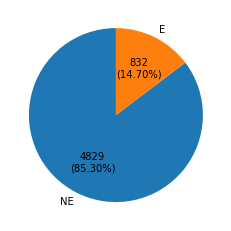

In [8]:
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
labels = df_label.loc[selectedgenes][labelname].values
distrib = Counter(labels)
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  
classes_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
rev_classes_mapping = np.array(list(classes_mapping.keys()))
def absvaluess(p):
  return '{:.0f}\n({:.2f}%)'.format(p * len(y) / 100, p)
plt.pie(list(distrib.values()), labels=list(distrib.keys()), autopct=absvaluess, startangle=90)
print(bcolors.HEADER + f'Show label distribution ...' + bcolors.ENDC)
print(bcolors.OKGREEN + f'\tWorking on label "{labelname}": {classes_mapping} {rev_classes_mapping} {dict(distrib)}' + bcolors.ENDC)


# Classification

Classification with method "LGBM"...


5-fold: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


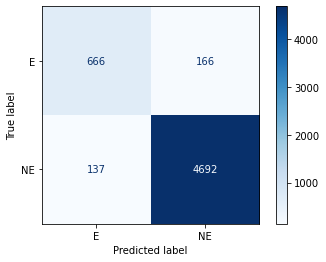

+------+-------------+-------------+---------------+---------------+-------------+---------------+
|      | Accuracy    | BA          | Sensitivity   | Specificity   | MCC         | CM            |
|------+-------------+-------------+---------------+---------------+-------------+---------------|
| LGBM | 0.946±0.005 | 0.886±0.018 | 0.801±0.040   | 0.972±0.006   | 0.784±0.023 | [[ 666  166]  |
|      |             |             |               |               |             |  [ 137 4692]] |
+------+-------------+-------------+---------------+---------------+-------------+---------------+


In [9]:
#@title Choose classifier { run: "auto", form-width: "20%" }
method = "LGBM" #@param ["SVM", "XGB", "RF", "MLP", "RUS", "LGBM"]
import random
random.seed(seed)
np.random.seed(seed)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.neural_network import MLPClassifier
import sys
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from tabulate import tabulate
nfolds = 5
kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=seed)
accuracies, mccs = [], []
genes = x.index.values
X = x.to_numpy()

nclasses = len(classes_mapping)
cma = np.zeros(shape=(nclasses,nclasses), dtype=int)
mm = np.array([], dtype=int)
gg = np.array([])
yy = np.array([], dtype=int)
predictions = np.array([])
columns_names = ["Accuracy","BA", "Sensitivity", "Specificity","MCC", 'CM']
scores = pd.DataFrame(columns=columns_names)
print(bcolors.HEADER + f'Classification with method "{method}"...')
for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(np.arange(len(X)), y), total=kf.get_n_splits(), desc=bcolors.OKGREEN +  f"{nfolds}-fold")):
    train_x, train_y, test_x, test_y = X[train_idx], y[train_idx], X[test_idx], y[test_idx],
    mm = np.concatenate((mm, test_idx))
    yy = np.concatenate((yy, test_y))
    gg = np.concatenate((gg, genes[test_idx]))
    clf = globals()[classifier_map[method]](**classifiers_args[method])
    preds = clf.fit(train_x, train_y).predict(test_x)
    cm = confusion_matrix(test_y, preds)
    cma += cm.astype(int)
    predictions = np.concatenate((predictions, preds))
    scores = scores.append(pd.DataFrame([[accuracy_score(test_y, preds), balanced_accuracy_score(test_y, preds), 
        cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,0]+cm[1,1]), 
        matthews_corrcoef(test_y, preds), cm]], columns=columns_names, index=[fold]))
dfm_scores = pd.DataFrame(scores.mean(axis=0, numeric_only=True)).T
dfs_scores = pd.DataFrame(scores.std(axis=0, numeric_only=True)).T
df_scores = pd.DataFrame([f'{row[0]:.3f}±{row[1]:.3f}' for row in pd.concat([dfm_scores,dfs_scores], axis=0).T.values.tolist()]).T
df_scores.index=[f'{method}']
df_scores['CM'] = [cma]
df_scores.columns = columns_names
disp = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=encoder.inverse_transform(clf.classes_))
disp.plot(cmap="Blues")
plt.show()
print(bcolors.OKGREEN +  tabulate(df_scores, headers='keys', tablefmt='psql') + bcolors.ENDC)